# LSTM on Amazon Food Reviews

Dataset Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of the fine food from Amazon.

Timespan: Oct 1999 - Oct 2012
Total Number of Reviews: 568,454
Total Number of Users: 256,059
Total Number of Products: 74,258
Total Number of Profile Name: 218,418

Number of attributes/columns: 10

Attributes/Columns:

1. Id: Row Id
2. ProductId: Unique identifier for the product
3. UserId: Unqiue identifier for the user
4. ProfileName: Profile name of the user
5. HelpfulnessNumerator: Number of users who found the review helpful
6. HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not
7. Score: Rating between 1 and 5
8. Time: Timestamp for the review
9. Summary: Brief summary of the review
10. Text: Text of the review

**Aim: Convert all the reviews into a vector using BoW**

**Then perform following tasks under each technique:**
1. Construct vocabulary of all the words in reviews.
2. Construct table which contains frequency of each word in all the reviews.
3. Sort the frequency table in descending order then assign index to each word. Top words will get index 1, second word will get index 2 and so on.
4. Replace every word in all the reviews with its corresponding index which you have created in step 3.
5. Apply padding to each review and make length of each review to 800.
6. Split train and test data in a ratio of 80:20 then apply two layer LSTM and predict the polarity of each review in test data. Finally check test accuracy.


# Loading the data

The dataset is available in two forms on kaggle:

1. .csv file

2. SQLite Database

To load data, I have used SQLite dataset as it is easier to query and visualise the data.Here I have to classifiy the sentiment into positive and negative, so I will ignore all the reviews with Scores equal to 3.If the Score is greater than 3 then it is positive otherwise it is negative.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
conn=sqlite3.connect('CleanedAmazonFoodReviewDataset.sqlite')

In [3]:
dataset=pd.read_sql_query("SELECT * FROM REVIEWS",conn)

In [4]:
dataset.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanutsth peanu...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [5]:
dataset.shape

(364171, 12)

In [6]:
dataset["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [7]:
def changeScore(score):
    if(score=="Positive"):
        return 1
    else:
        return 0

In [8]:
scores=list(dataset["Score"])

In [9]:
convertedScore=list(map(changeScore,scores))

In [10]:
convertedScore[:10]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [11]:
dataset["Score"]=convertedScore

In [12]:
dataset.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanutsth peanu...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [13]:
allPositiveReviews=dataset[dataset["Score"]==1]

In [14]:
allPositiveReviews.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...
5,6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,this saltwat taffi had great flavor and was ve...


In [15]:
allPositiveReviews.shape

(307061, 12)

In [16]:
positiveReviews10000=allPositiveReviews[:10000]

In [17]:
positiveReviews10000.shape

(10000, 12)

In [18]:
positiveReviews10000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...
5,6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,this saltwat taffi had great flavor and was ve...


In [19]:
allNegativeReviews=dataset[dataset["Score"]==0]

In [20]:
allNegativeReviews.shape

(57110, 12)

In [21]:
allNegativeReviews.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanutsth peanu...
11,12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,cat have been happili eat felida platinum for ...
15,16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,0,1348099200,poor taste,I love eating them and they are good for watch...,love eat them and they are good for watch and ...
25,26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,0,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",the candi just red flavor just plan and chewi ...
45,47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,0,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",this oatmeal not good it mushi soft dont like ...


In [22]:
negativeReviews10000=allNegativeReviews[:10000]

In [23]:
negativeReviews10000.shape

(10000, 12)

In [24]:
negativeReviews10000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanutsth peanu...
11,12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,cat have been happili eat felida platinum for ...
15,16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,0,1348099200,poor taste,I love eating them and they are good for watch...,love eat them and they are good for watch and ...
25,26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,0,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",the candi just red flavor just plan and chewi ...
45,47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,0,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",this oatmeal not good it mushi soft dont like ...


In [25]:
dataframe20000=[positiveReviews10000,negativeReviews10000]

In [26]:
finalDataFrame20000=pd.concat(dataframe20000)

In [27]:
finalDataFrame20000.shape

(20000, 12)

In [28]:
finalDataFrame20000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...
5,6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,this saltwat taffi had great flavor and was ve...


In [29]:
finalSortedDataFrame20000=finalDataFrame20000.sort_values('Time',inplace=False,axis=0,ascending=True)

In [30]:
finalSortedDataFrame20000.shape

(20000, 12)

In [31]:
finalSortedDataFrame20000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
772,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,this was realli good idea and the final produc...
771,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,just receiv shipment and could hard wait tri t...
7852,10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,when chatchi favorit afternoon treat becam mys...
5822,7427,8111,B0000EIE2Z,A3M174IC0VXOS2,Gail Cooke,3,3,1,1075420800,BEST BLUEBERRIES,In the winter when fresh blueberries exceed ou...,the winter when fresh blueberri exceed our foo...
7179,10116,11049,B0000VYKXC,A3L88AH6MABEDL,Javier Denison,0,0,1,1081209600,Best coffee I've tasted. I try others but alwa...,If you like a strong but smooth flavorful coff...,you like strong but smooth flavor coffe this h...


In [32]:
finalSortedDataFrameScore20000=finalSortedDataFrame20000["Score"]

In [33]:
finalSortedDataFrameScore20000.shape

(20000,)

In [34]:
finalSortedDataFrameScore20000.head()

772     1
771     1
7852    1
5822    1
7179    1
Name: Score, dtype: int64

In [41]:
final_data=finalSortedDataFrame20000

In [42]:
final_data.shape

(20000, 12)

In [43]:
final_data_labels=finalSortedDataFrameScore20000

In [44]:
final_data_labels.shape

(20000,)

# BoW

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

**Construct vocabulary of all the words in reviews.**

In [46]:
cv=CountVectorizer()
bow=cv.fit_transform(final_data["ProcessedText"].values)

In [47]:
type(bow), bow.shape

(scipy.sparse.csr.csr_matrix, (20000, 21699))

In [48]:
bow_features=cv.get_feature_names()
type(bow_features),len(bow_features)

(list, 21699)

**Construct table which contains frequency of each word in all the reviews.**

In [49]:
c=[]
for i in range(len(bow_features)):
    t=bow.getcol(i).sum()
    c.append(t)

In [50]:
len(c)

21699

In [51]:
frequencyTable=dict(zip(bow_features,c))

**Sort the frequency table in descending order then assign index to each word. Top words will get index 1, second word will get index 2 and so on.**

In [52]:
frequencyTable_sort=sorted(frequencyTable.items(),key=lambda frequencyTable: frequencyTable[1],reverse=True)

In [53]:
for i in range(100):
    print(frequencyTable_sort[i])

('the', 71123)
('and', 45141)
('this', 25172)
('for', 18799)
('that', 16997)
('not', 14429)
('was', 14184)
('but', 13647)
('have', 12878)
('with', 12608)
('you', 11563)
('they', 10706)
('are', 10675)
('like', 10476)
('tast', 10465)
('these', 8299)
('product', 7736)
('them', 7532)
('flavor', 6828)
('one', 6754)
('good', 6619)
('just', 6369)
('tri', 6174)
('can', 6143)
('veri', 5968)
('use', 5961)
('it', 5826)
('all', 5797)
('from', 5779)
('had', 5441)
('coffe', 5419)
('would', 5244)
('love', 4896)
('when', 4792)
('will', 4682)
('get', 4634)
('great', 4508)
('more', 4472)
('has', 4426)
('out', 4378)
('other', 4376)
('make', 4333)
('food', 4240)
('tea', 4142)
('buy', 4088)
('were', 3929)
('than', 3920)
('your', 3832)
('dog', 3632)
('dont', 3626)
('there', 3594)
('eat', 3586)
('what', 3583)
('some', 3560)
('realli', 3556)
('order', 3549)
('about', 3529)
('time', 3437)
('onli', 3401)
('much', 3350)
('even', 3252)
('drink', 3212)
('becaus', 3196)
('too', 3189)
('bag', 3032)
('amazon', 3019)


In [54]:
from wordcloud import WordCloud

In [55]:
def PlotWordCloud(frequency):
    wordCloudPlot=WordCloud(background_color="white",width=150,height=80)
    wordCloudPlot.generate_from_frequencies(frequencies=frequency)
    plt.figure(figsize=(15,10))
    plt.imshow(wordCloudPlot,interpolation="bilinear")
    plt.axis("off")
    plt.show()

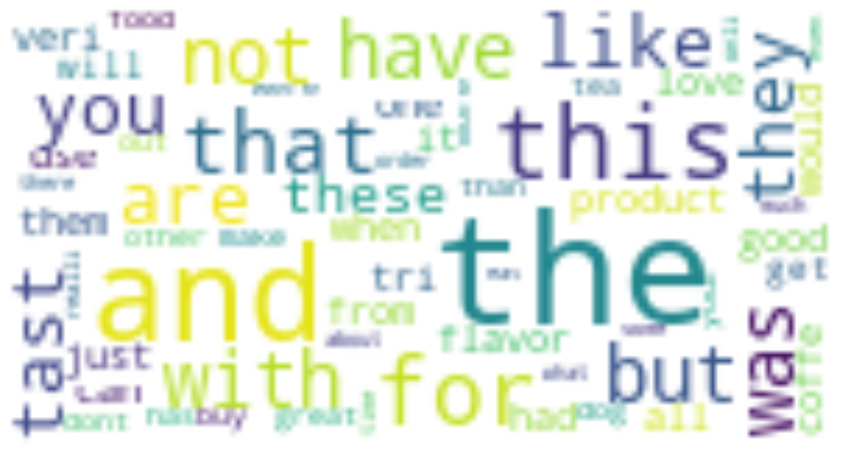

In [56]:
PlotWordCloud(frequencyTable)

In [57]:
frequencyTable_sort_dict=dict(frequencyTable_sort)

In [58]:
c=0
for key,value in frequencyTable_sort_dict.items():
    c+=1
    frequencyTable_sort_dict[key]=c

In [59]:
c=0
for pair in frequencyTable_sort_dict.items():
    if(c<100):
        print(pair)
        c+=1

('the', 1)
('and', 2)
('this', 3)
('for', 4)
('that', 5)
('not', 6)
('was', 7)
('but', 8)
('have', 9)
('with', 10)
('you', 11)
('they', 12)
('are', 13)
('like', 14)
('tast', 15)
('these', 16)
('product', 17)
('them', 18)
('flavor', 19)
('one', 20)
('good', 21)
('just', 22)
('tri', 23)
('can', 24)
('veri', 25)
('use', 26)
('it', 27)
('all', 28)
('from', 29)
('had', 30)
('coffe', 31)
('would', 32)
('love', 33)
('when', 34)
('will', 35)
('get', 36)
('great', 37)
('more', 38)
('has', 39)
('out', 40)
('other', 41)
('make', 42)
('food', 43)
('tea', 44)
('buy', 45)
('were', 46)
('than', 47)
('your', 48)
('dog', 49)
('dont', 50)
('there', 51)
('eat', 52)
('what', 53)
('some', 54)
('realli', 55)
('order', 56)
('about', 57)
('time', 58)
('onli', 59)
('much', 60)
('even', 61)
('drink', 62)
('becaus', 63)
('too', 64)
('bag', 65)
('amazon', 66)
('box', 67)
('which', 68)
('price', 69)
('also', 70)
('been', 71)
('after', 72)
('look', 73)
('better', 74)
('littl', 75)
('find', 76)
('ani', 77)
('mix', 7

**Replace every word in all the reviews with its corresponding index which you have created in step 3.**

In [60]:
indexReviews=[]
for sentence in final_data["ProcessedText"].values:
    filterReviews=[]
    for word in sentence.split():
        index=frequencyTable_sort_dict[word]
        filterReviews.append(index)
    indexReviews.append(filterReviews)

In [61]:
len(indexReviews)

20000

In [62]:
indexReviews[0]

[3,
 7,
 55,
 21,
 472,
 2,
 1,
 497,
 17,
 1551,
 26,
 1,
 8938,
 1492,
 1784,
 2,
 2496,
 530,
 297,
 94,
 1,
 8938,
 95,
 111,
 2174]

In [63]:
len(indexReviews[0])

25

In [64]:
c=0
for i in indexReviews:
    c+=1
    if(len(i)>800):
        print(c)

1950
3981
5683


In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


**Apply padding to each review and make length of each review to 800**

In [66]:
max_dim=800
reviews=sequence.pad_sequences(indexReviews,maxlen=max_dim)

In [67]:
reviews.shape

(20000, 800)

In [68]:
reviews[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

**Split train and test data in a ratio of 80:20 then apply two layer LSTM and predict the polarity of each review in test data. Finally check test accuracy.**

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
X_train,X_test,y_train,y_test=train_test_split(reviews,final_data_labels,test_size=0.2,random_state=42)

In [71]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((16000, 800), (4000, 800), (16000,), (4000,))

In [72]:
embedding_vector_len=32
model=Sequential()
model.add(Embedding(len(bow_features)+1,embedding_vector_len,input_length=max_dim))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 800, 32)           694400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 800, 64)           24832     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 731,681
Trainable params: 731,681
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.fit(X_train,y_train,epochs=4,batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/4
16000/16000 [==============================] - 1160s 73ms/step - loss: 0.4760 - acc: 0.7761
Epoch 2/4
16000/16000 [==============================] - 537s 34ms/step - loss: 0.2555 - acc: 0.9023
Epoch 3/4
16000/16000 [==============================] - 458s 29ms/step - loss: 0.1820 - acc: 0.9354
Epoch 4/4
16000/16000 [==============================] - 474s 30ms/step - loss: 0.1457 - acc: 0.9517


In [75]:
y_pred=model.predict(X_test)

In [76]:
y_pred.shape

(4000, 1)

In [77]:
predict=[]
for i in y_pred:
    if(i>0.5):
        predict.append(1)
    else:
        predict.append(0)

In [78]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [79]:
X_test.shape

(4000, 800)

In [80]:
accuracy = accuracy_score(y_test, predict)
accuracy

0.865

In [81]:
cm=confusion_matrix(y_test, predict)
cm

array([[1719,  263],
       [ 277, 1741]], dtype=int64)

**Accuracy = 86.5%**